# Capstone project by Leonard Veillon
# Shopify e-commerce order predictor

## 4) Machine learning 

### (a) Phrase your project goal as a clear machine learning question

**Question:** What accuracy in terms of f1 score can we achieve by predicting if a visit will generate an order or not based on the available features?

**Type of problem:** Binary classification problem

**Target:** `orders_placed` {0,1}

**Features:**
- Numerical: `page_views`, `carts`, `checkouts`, `avg_duration`, `bounce_rate`
- One-hot encoded: `referrer_source`, `referrer_host`, `referrer_url`, `device`, `page_type`, `page_path`, `page_url`, `country`, `region`, `city`
- Engineered: `hour_of_day`, `day_of_week`, `month`, `year`, `day_in_month`, `shipping`, `legal`

### (b) What models are you planning to use and why?

**Baseline:** - Create a "most frequent" baseline to see the performance of a dummy classifier.

**k-NN:** - Good for classification tasks as the model compares values with their neighbors. Good baseline with reasonable performance in most cases.

**Random Forest:** - if-then-else rules are perfect for this kind of data. Bootstrapping can improve the decision Tree model even more.

**Logistic Regression:** - Good classification model thanks to the sigmoid function. A regression model can look simple compared to some other models. But sometimes, simple is better.

### (c) Please tell us your detailed machine learning strategy 

- Split into train et tests sets using stratified sampling (stratify=y)
- For each model, create a GridSearchCV object which allows us to add `f1` as score
- Create a pipeline and standardize data for distanced-based models
- Use balanced class weight
- Create and fill a grid parameter dict in order to fine-tune hyperparameters
- Fit models
- Compare test set performance with f1 score, confusion matrix, classification report
- Do some prediction probabilities analysis between models.
    
Useful sources:  
https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v2/subjects/k-nearest-neighbors-v2/units/baseline-for-classification-v2
https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline

# Matplotlib params
plt.rcParams['figure.dpi']= 100
plt.rc('axes', axisbelow=True)
plt.style.use('dark_background')

# Prepare data

## Read data

In [2]:
# Read processed dataframe
data = pd.read_csv('data/data_processed.csv')
print('features :', list(data.drop('orders_placed', axis=1).columns))
print('target : order_placed')

# Encode new dataframe
to_encode = ['referrer_source', 'referrer_host', 'device', 'page_type',
             'page_url', 'page_path', 'country', 'region', 'city']

encoded_df = pd.get_dummies(data, columns=to_encode, drop_first=False)
print('\nEncoded shape: ', encoded_df.shape)

features : ['referrer_source', 'referrer_host', 'device', 'page_type', 'page_url', 'page_path', 'country', 'region', 'city', 'page_views', 'carts', 'checkouts', 'avg_duration', 'bounce_rate', 'hour_of_day', 'day', 'month', 'year', 'day_in_month', 'shipping', 'legal']
target : order_placed

Encoded shape:  (12240, 46)


## Preprocess

In [3]:
def preprocess(df):
    # Create X/y arrays
    X = df.drop('orders_placed', axis=1).values
    y = df.orders_placed.values

    # Split data
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    print('Train:', X_tr.shape, y_tr.shape)
    print('Test:', X_te.shape, y_te.shape)

    # Check stratify
    #print('\nStratify train:\n', pd.value_counts(y_tr, normalize=True), '\n\nStratify test:\n', pd.value_counts(y_te, normalize=True))
    
    return X_tr, X_te, y_tr, y_te

In [4]:
X_tr, X_te, y_tr, y_te = preprocess(encoded_df)

Train: (9792, 45) (9792,)
Test: (2448, 45) (2448,)


## Custom Functions for visualization

In [5]:
#####################################
### Draw Confusion Matrix heatmap ###
#####################################

# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

def draw_cf_matrix(cf_matrix=None):
    
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    # trick log scale
    cf_matrix2 = cf_matrix
    cf_matrix2 += 1
    
    fig, ax = plt.subplots(1,1)
    cbar_kws = {"ticks" : np.power(10, np.arange(5))}
    ax = sns.heatmap(cf_matrix2, annot=labels, fmt='', cmap='Blues_r', norm=LogNorm(), cbar_kws=cbar_kws)
    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['No order','Order'])
    ax.yaxis.set_ticklabels(['No order','Order'])

    ## Display the visualization of the Confusion Matrix.
    fig.tight_layout()
    plt.show()

    
#####################
### annotate bars ###
#####################

# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() - 0.05
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", color='black') 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
######################
### Visualize Tree ###
######################

import graphviz
from sklearn.tree import export_graphviz

# Export decision tree
def visualize_tree(model):
    graph = export_graphviz(model, out_file=None,
                        feature_names=encoded_df.drop('orders_placed', axis=1).columns,
                        class_names=['no_order', 'order'], filled=True, rounded=True, proportion=True)

    graphviz.Source(graph)

# Machine learning Models

### Baseline Model

In [6]:
def model_baseline(X_tr, X_te, y_tr, y_te):
    
    print('\n### baseline ###\n')

    # Create the dummy classifier
    dummy = DummyClassifier(strategy='most_frequent')

    # Fit it
    dummy.fit(None, y_tr)

    # Predictions
    y_pred = dummy.predict(X_tr)
    
    # Confusion matrix
    draw_cf_matrix(confusion_matrix(y_true=y_tr, y_pred=y_pred))
    
    # Classification report
    print('\nClassification report:')
    print(classification_report(y_tr, y_pred))
      
    # f1 score
    f1_tr = f1_score(y_tr, y_pred)
    print('f1 score = %0.3f\n' % f1_tr)

    # Predictions with test set
    y_pred = dummy.predict(X_te)
    y_proba = dummy.predict_proba(X_te)
          
    return y_pred, f1_tr, y_proba

### k-NN Model

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def model_kNN(X_tr, X_te, y_tr, y_te):
    
    print('\n### kNN ###\n')

    # Create k-NN classifier
    knn = KNeighborsClassifier(
        n_neighbors=5,
        algorithm='brute', 
        weights='distance' # uniform: neighbors equally weighted, distance: neighbors weighted on distance to point 
    )

    knn_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', knn)
    ])

    # gridsearch
    grid = {'knn__n_neighbors': np.arange(1, 25, 1), # number of neighbors
            'knn__weights': ['uniform', 'distance'],
            'knn__p': [1, 2]} # Regularization term

    gridsearch = GridSearchCV(estimator=knn_pipe, param_grid=grid, n_jobs=-1, cv=5, scoring='f1')

    # fit
    gridsearch.fit(X_tr, y_tr)
    cv_results = gridsearch.cv_results_
    cv_results = pd.DataFrame(cv_results)
    #print(cv_results)

    # Plot
    plt.plot(cv_results.param_knn__n_neighbors, cv_results.mean_train_score, label='train')
    plt.plot(cv_results.param_knn__n_neighbors, cv_results.mean_test_score, label='val')
    plt.fill_between(list(cv_results.param_knn__n_neighbors), cv_results.mean_train_score-cv_results.std_train_score, cv_results.mean_train_score+cv_results.std_train_score, alpha=0.2)
    plt.fill_between(list(cv_results.param_knn__n_neighbors), cv_results.mean_test_score-cv_results.std_test_score, cv_results.mean_test_score+cv_results.std_test_score, alpha=0.2)
    plt.scatter(gridsearch.best_params_['knn__n_neighbors'], gridsearch.best_score_, marker='x', c='blue', zorder=10)
    plt.title('Validation curves')
    plt.xlabel('k')
    plt.ylabel('f1 score')
    plt.legend()
    plt.show()
    
    y_pred, f1_tr, f1_te, y_proba = model_output(gridsearch)
    
    return y_pred, f1_tr, f1_te, y_proba, cv_results

### Random Forest

In [120]:
from sklearn.ensemble import RandomForestClassifier

def model_rf(X_tr, X_te, y_tr, y_te, grid):

    print('\n### Random Forest ###\n')

    # Create a decision tree
    rf = RandomForestClassifier(
        n_estimators='warn', max_depth=None, random_state=0, class_weight='balanced')

    rf_pipe = Pipeline([('rf', rf)])
    
    gridsearch = GridSearchCV(estimator=rf_pipe, param_grid=grid, n_jobs=-1, cv=5, scoring='f1')

    # fit
    gridsearch.fit(X_tr, y_tr)
    cv_results = gridsearch.cv_results_
    cv_results = pd.DataFrame(cv_results)
    #print(gridsearch.best_params_)

    # Plot
    sns.lineplot(data=cv_results, x='param_rf__max_depth', y='mean_train_score', label='train')
    sns.lineplot(data=cv_results, x='param_rf__max_depth', y='mean_test_score', label='val')
    #plt.fill_between(list(cv_results.param_max_depth), cv_results.mean_train_score-cv_results.std_train_score, cv_results.mean_train_score+cv_results.std_train_score, alpha=0.2)
    plt.fill_between(list(cv_results.param_rf__max_depth), cv_results.mean_test_score-cv_results.std_test_score, cv_results.mean_test_score+cv_results.std_test_score, alpha=0.2)
    plt.scatter(gridsearch.best_params_['rf__max_depth'], gridsearch.best_score_, marker='x', c='blue', zorder=10)

    plt.title('Validation curves')
    plt.xlabel('depth')
    plt.ylabel('f1')
    plt.legend()
    plt.show()

    y_pred, f1_tr, f1_te, y_proba = model_output(gridsearch)
    
    return y_pred, f1_tr, f1_te, y_proba, gridsearch

In [76]:
# Draw features importances
feature_names = encoded_df.drop('orders_placed', axis=1).columns

def draw_importance(rf_tree):
    importances = rf_tree.best_estimator_.named_steps['rf'].feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_tree.best_estimator_.named_steps['rf'].estimators_], axis=0)
    

    rf_importances = pd.Series(importances, index=feature_names)
    rf_importances.sort_values(ascending=False, inplace=True)

    fig, ax = plt.subplots(figsize=(12,5))
    rf_importances[rf_importances.abs().sort_values(ascending = False).index].plot.bar(ax=ax, yerr=std)
    ax.set_title("Random Forest Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    ax.set_xlabel("Feature")
    #ax.set_ylim(-.05,.5)
    ax.grid(color='gray', alpha=.2, axis='both')
    fig.tight_layout()


In [10]:
# Draw trees

from sklearn.tree import export_graphviz
import graphviz

def draw_tree(rf_tree, filename):
    # Export decision tree
    dot_data = export_graphviz(
        rf_tree.best_estimator_.named_steps['rf'].estimators_[0], class_names=['no order', 'order'], # tree number 1 
        filled=True, rounded=True, proportion=True, feature_names=encoded_df.drop('orders_placed', axis=1).columns 
    )

    # Save png image and render
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render(filename,view=True)

    # Display decision tree in Jupyter
    return graphviz.Source(dot_data)

    # entropy - the impurity measure at this node
    # samples - the percentage of samples in this node
    # value - the probabilities for each class
    # class - the class with the highest probability

### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

def model_lr(X_tr, X_te, y_tr, y_te):
    
    scaler = StandardScaler() # features same scale
    logistic = LogisticRegression(class_weight='balanced') #minimize Cross-Entropy

    pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

    # Grid
    param_grid = [
        {"logistic__C": np.logspace(-4, 4, 4), # Inverse of regularization term
         'logistic__penalty': ["l2"],
   #      'logistic__fit_intercept': [True, False],
   #      'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        },{
            "logistic__C": np.logspace(-4, 4, 4),
            'logistic__penalty': ["l1"],
   #         'logistic__fit_intercept': [True, False],
   #         'logistic__solver': ['liblinear', 'saga']
        }]

    gridsearch = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1')
    
    # Fit
    gridsearch.fit(X_tr, y_tr)
    cv_results = gridsearch.cv_results_
    cv_results = pd.DataFrame(cv_results)

    # Plot
    sns.lineplot(data=cv_results, x='param_logistic__C', y='mean_train_score', label='train')
    sns.lineplot(data=cv_results, x='param_logistic__C', y='mean_test_score', label='val')
    #plt.fill_between(list(cv_results.param_max_depth), cv_results.mean_train_score-cv_results.std_train_score, cv_results.mean_train_score+cv_results.std_train_score, alpha=0.2)
    plt.fill_between(list(cv_results.param_logistic__C), cv_results.mean_test_score-cv_results.std_test_score, cv_results.mean_test_score+cv_results.std_test_score, alpha=0.2)
    plt.scatter(gridsearch.best_params_['logistic__C'], gridsearch.best_score_, marker='x', c='blue', zorder=10)

    plt.title('Validation curves')
    plt.xlabel('C')
    plt.ylabel('f1')
    plt.xscale('log')
    plt.legend()
    plt.show()

    y_pred, f1_tr, f1_te, y_proba = model_output(gridsearch)
    
    return y_pred, f1_tr, f1_te, y_proba, gridsearch

### Scores function

In [6]:
def model_output(gridsearch):
    
    # Best params
    print("Best params: {}".format(gridsearch.best_params_))
    print("f1 validation score = %0.3f\n" % gridsearch.best_score_)

    # Confusion matrix
    draw_cf_matrix(confusion_matrix(y_tr, gridsearch.predict(X_tr)))

    # Classification report
    print('\nClassification report [whole train set]:\n')
    print(classification_report(y_tr, gridsearch.predict(X_tr)))

    # f1 score
    f1_tr = f1_score(y_tr, gridsearch.predict(X_tr))
    print("f1 train score = %0.3f\n" % f1_tr)

    ### TEST SET ###
    print('### test set ###\n')

    # Predictions
    y_true, y_pred = y_te, gridsearch.predict(X_te)

    # Confusion matrix
    draw_cf_matrix(confusion_matrix(y_true, y_pred))

    # Classification report
    print('\nClassification report:\n')
    print(classification_report(y_true, y_pred))

    # f1 score
    f1_te = f1_score(y_true, y_pred)
    print("f1 test score = %0.3f\n" % f1_te)

    # Predictions with test set
    y_proba = gridsearch.predict_proba(X_te)

    return y_pred, f1_tr, f1_te, y_proba

# Train Full Models with grid search

### Baseline model

Train: (9792, 45) (9792,)
Test: (2448, 45) (2448,)

### baseline ###



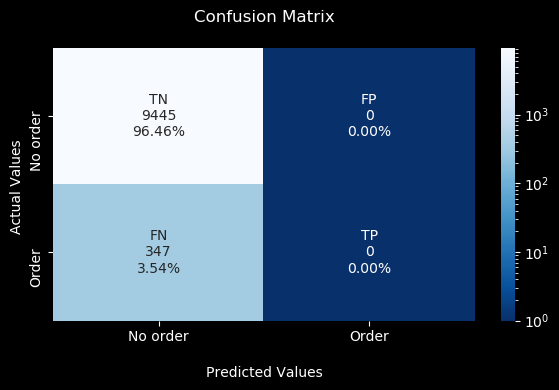


Classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9445
           1       0.00      0.00      0.00       347

   micro avg       0.96      0.96      0.96      9792
   macro avg       0.48      0.50      0.49      9792
weighted avg       0.93      0.96      0.95      9792

f1 score = 0.000



In [13]:
### Full model
encoded_df_full = encoded_df
X_tr, X_te, y_tr, y_te = preprocess(encoded_df_full)

# Baseline
baseline_full_pred, baseline_full_f1, baseline_full_proba = model_baseline(X_tr, X_te, y_tr, y_te)

The baseline model predicts always `0` as it is the most common value. As expected, accuracy is 96% but the resulting f1-score is 0.

### kNN


### kNN ###



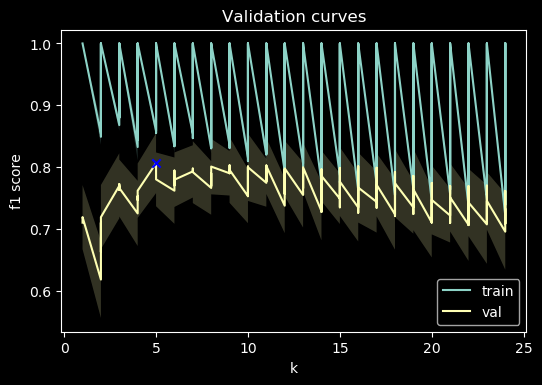

Best params: {'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}
f1 validation score = 0.807



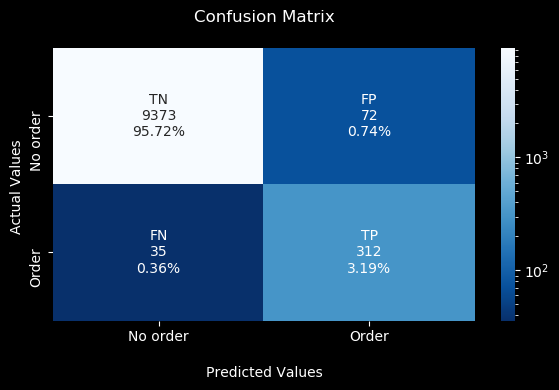


Classification report [whole train set]:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9445
           1       0.81      0.90      0.85       347

   micro avg       0.99      0.99      0.99      9792
   macro avg       0.90      0.95      0.92      9792
weighted avg       0.99      0.99      0.99      9792

f1 train score = 0.854

### test set ###



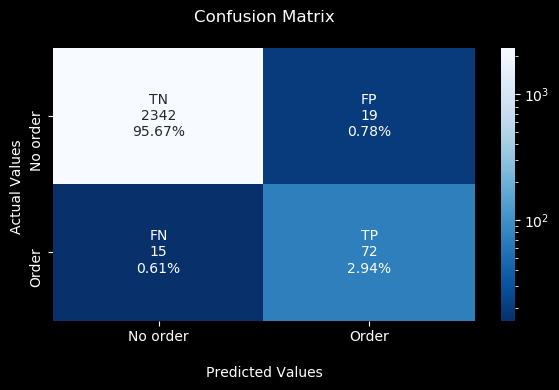


Classification report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2361
           1       0.79      0.83      0.81        87

   micro avg       0.99      0.99      0.99      2448
   macro avg       0.89      0.91      0.90      2448
weighted avg       0.99      0.99      0.99      2448

f1 test score = 0.809



In [14]:
# kNN
# Score metric [‘f1’, ‘f1_micro’, ‘f1_macro’, ‘f1_weighted’, 'precision', 'recall']
kNN_full_pred, kNN_full_f1_tr, kNN_full_f1_te, kNN_full_proba, cv_results_knn  = model_kNN(X_tr, X_te, y_tr, y_te)

In [15]:
#cv_results_knn.sort_values('mean_test_score', ascending=False)

The best kNN model uses 5 neighbors, l1 distance and distance weights. It reaches an f1-score of 80.1% on the test set from 85% for the train set.

A slightly lower proportion of TP are found on the test set (2.94% vs 3.19%). The number of FN almost doubled (from 0.37% to 0.61%) which would suggest the model is overfitting.

We can see in the validation curves that the model is heavily overfitting with some parameters (train curve = 1). Fortunately, not with the best parameters.

- No_order category: 
    - Precision and recall are almost perfect with respective scores of 100% and 99%. This is in part due to the imbalance data.
- Order category:
    - Precision reaches 79%. There are 19 False Positive (FP) out of 91 predicted positive values.
    - Recall is slightly better with 83% and 15 FN. 

Let's look at the Random Forest Model which should perform better.

### Random Forest


### Random Forest ###



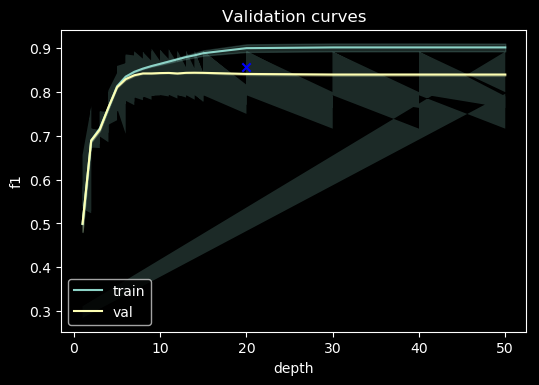

Best params: {'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__max_leaf_nodes': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100, 'rf__random_state': 0}
f1 validation score = 0.857



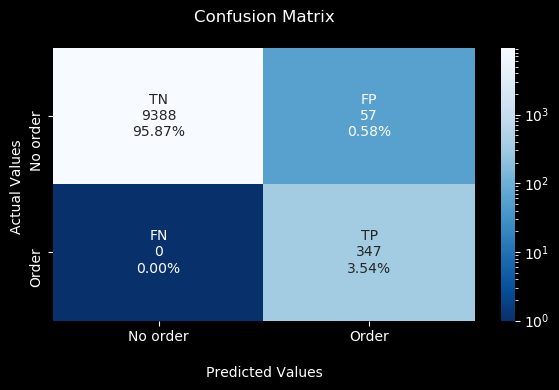


Classification report [whole train set]:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9445
           1       0.86      1.00      0.92       347

   micro avg       0.99      0.99      0.99      9792
   macro avg       0.93      1.00      0.96      9792
weighted avg       1.00      0.99      0.99      9792

f1 train score = 0.924

### test set ###



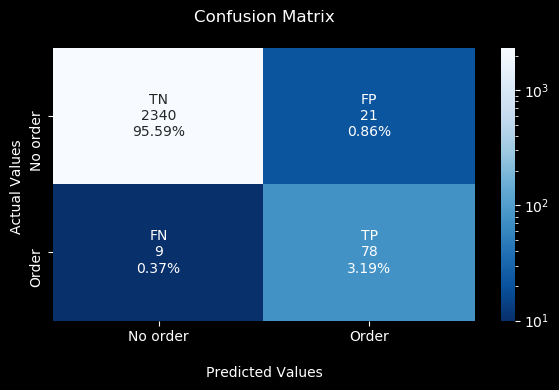


Classification report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2361
           1       0.79      0.90      0.84        87

   micro avg       0.99      0.99      0.99      2448
   macro avg       0.89      0.94      0.92      2448
weighted avg       0.99      0.99      0.99      2448

f1 test score = 0.839



In [16]:
# Random Forest

# gridsearch
grid = {'rf__criterion': ['gini','entropy'],
        'rf__bootstrap': [True],
        'rf__class_weight': ['balanced'],
        'rf__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20, 30, 40, 50],
        'rf__max_features': ['auto'],
        'rf__min_samples_leaf': [1, 2, 5],
        'rf__min_samples_split': [2, 3, 5],
        'rf__n_estimators': ['warn', 20, 30, 50, 100, 200, 400],
        'rf__random_state': [0],
        'rf__max_leaf_nodes': [None]
       }
    
rf_full_pred, rf_full_f1_tr, rf_full_f1_te, rf_full_proba, rf_tree = model_rf(X_tr, X_te, y_tr, y_te, grid)

The Random Forest model reach an f1-score of 84.5% from 93.3% with the train set.

The proportions of TP decreases while FP and FN increases. The train set did not see any FN which would suggest some overfitting.

- No_order category: 
    - Precision and recall are again almost perfect with respective scores of 100% and 99%.
- Order category:
    - Precision is at 80%, in line with the kNN model.
    - Recall is way better with a score of 91% (vs 83% for kNN). Only 5 FN out of 87 positive values.
    
Overall, we see an increase in recall performance going from kNN to Random Forest. 

#### Feature importance
We can check at the feature importance from the Random Forest Model

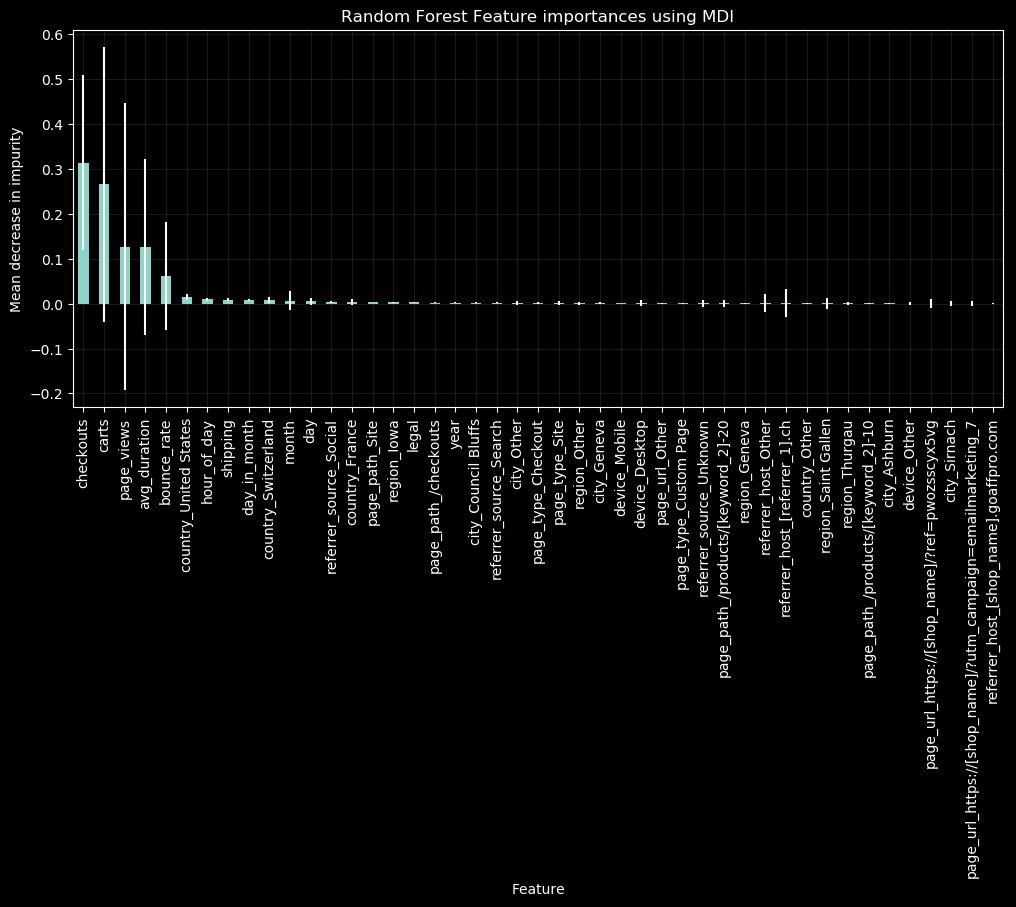

In [17]:
# Feature importance
draw_importance(rf_tree)

- The model use mainly the numerical features. `checkouts`, `carts`, `page_views` and `avg_duration` were the features that stood out in the EDA. It's not a surprise to see them here at the top. However, the standard deviations among trees are huge and goes in both directions (positive and negative). This is a sign that the model is not able to understand the data.  
- Furthermore, most of the other features are barely used by the model, it could be better to just remove them as it will significantly reduce the complexity of the model while marginaly impact the performance of the model (if not increasing it).



We can look at one of these trees and see how decisions are made.   
(Tree saved in .png in the directory in case it doesn't show up here)

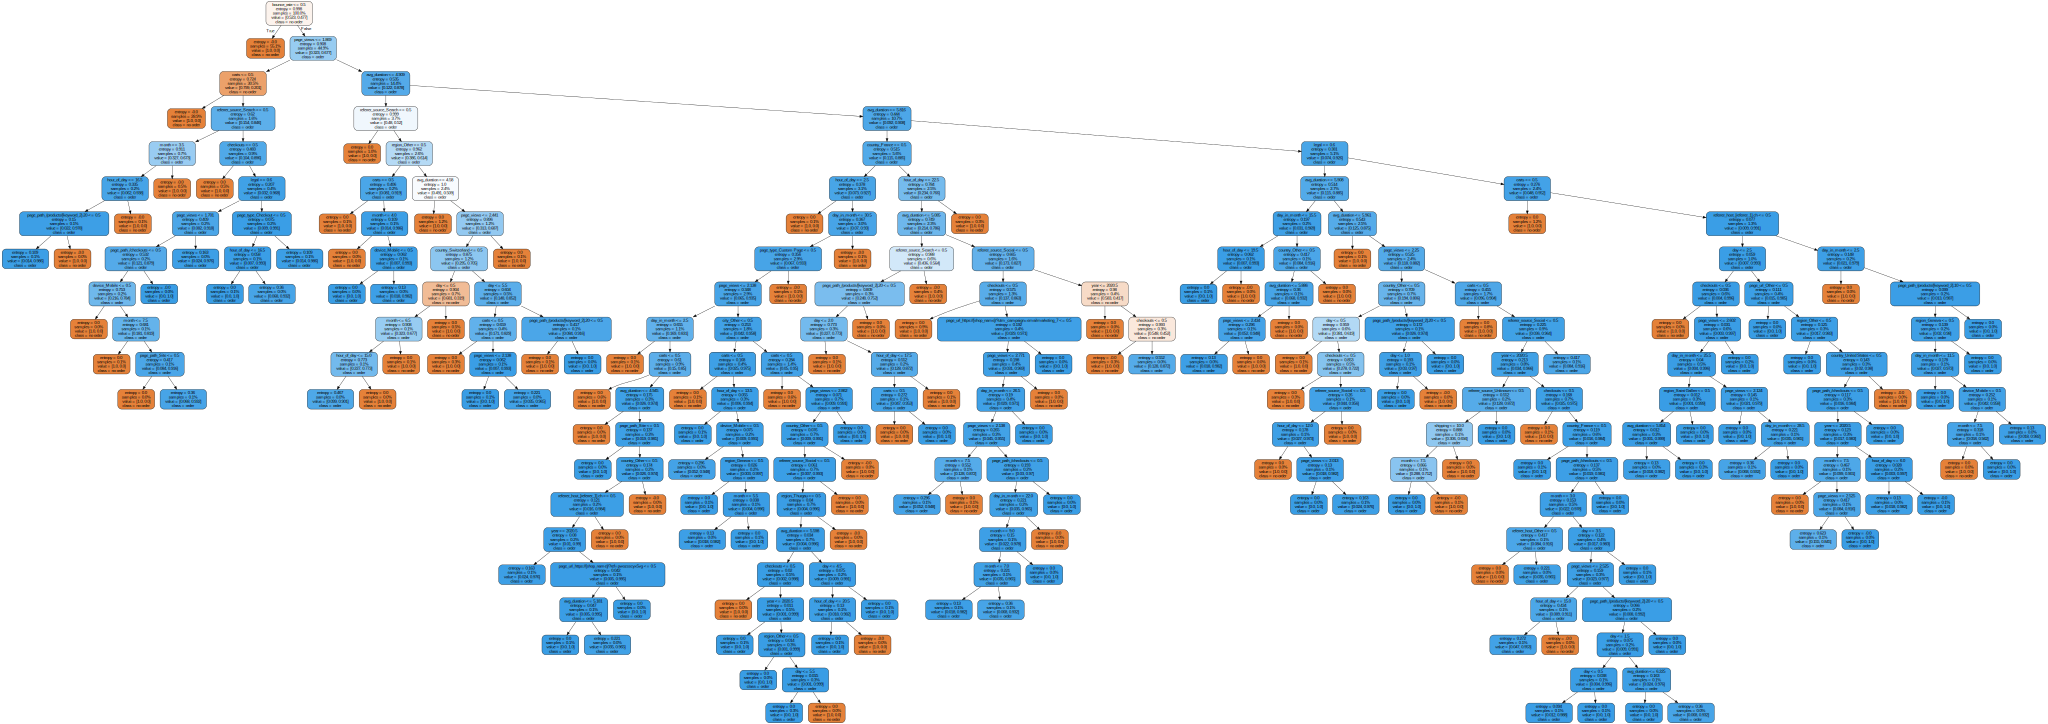

In [18]:
# Plot individual tree
draw_tree(rf_tree, 'Random_Forest_tree_1')

According to the entropy measure, `bounce_rate` is the most important feature. The node splits the samples between the ones that stays on the site (`bounce_rate` > 0.5) and the ones that leaves. As a result, samples on the left leaf are all from the `no_order` class. 

Then `page_views` is the second most important feature. Samples are splitted according to the number of pages visited on the site.
    
- Samples that are below the threshold (<= 1.869 in log scale) represent 30% of the data. In that leaf, only 20% of samples are from the class `order`. This node is further split based on the `carts` feature. 100% of samples with `carts` <= 0.5 are from the class `no order`. We end up with 1.6% of the data in the next node `referrer_source_Search`.

- On the second leaf from `page_views`, with the samples that are above the threshold, the probability of being from the class `order` is high (0.878).
    - The next 2 nodes are based on the feature `avg_duration` and separate the data between `avg_duration`<= 4.9 and `avg_duration`<= 5.816. They contain 14.4% and 10.7% of the data respectively. The class `order` is represented almost in the same proportions in both groups (0.878 vs 0.908) but that changes in their respective leaves that represent different behaviors on the site.
    - Then the branches become more complicated and less structured. Some features come back for example. This suggest the model is overfitting the data.

#### Simpler Random Forest Model
The model starts overfitting when the depth surpasses 10. We will try to make a simpler model.


### Random Forest ###



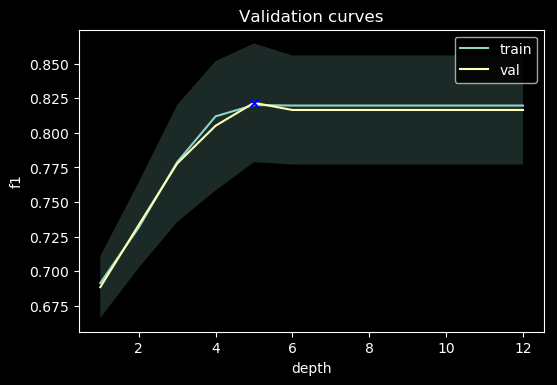

Best params: {'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__max_leaf_nodes': 10, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 5, 'rf__n_estimators': 100, 'rf__random_state': 0}
f1 validation score = 0.822



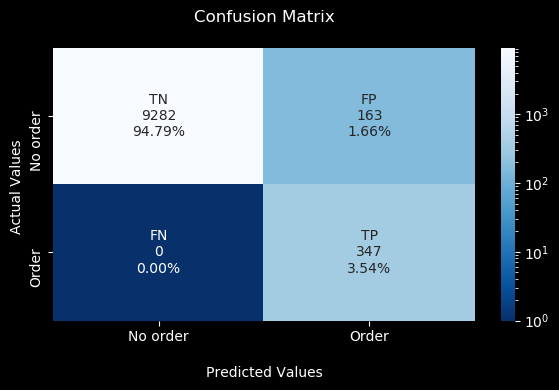


Classification report [whole train set]:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9445
           1       0.68      1.00      0.81       347

   micro avg       0.98      0.98      0.98      9792
   macro avg       0.84      0.99      0.90      9792
weighted avg       0.99      0.98      0.98      9792

f1 train score = 0.810

### test set ###



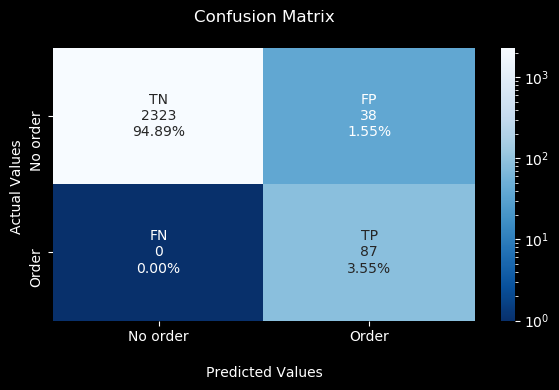


Classification report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2361
           1       0.70      1.00      0.82        87

   micro avg       0.98      0.98      0.98      2448
   macro avg       0.85      0.99      0.91      2448
weighted avg       0.99      0.98      0.99      2448

f1 test score = 0.821



In [171]:
# Best params: {'rf__bootstrap': True,
#               'rf__class_weight': 'balanced',
#               'rf__criterion': 'entropy',
#               'rf__max_depth': 20,
#               'rf__max_features': 'auto',
#               'rf__max_leaf_nodes': None,
#               'rf__min_samples_leaf': 1,
#               'rf__min_samples_split': 5,
#               'rf__n_estimators': 100,
#               'rf__random_state': 0}
    

# Best params:
grid = {'rf__bootstrap': [True],
        'rf__class_weight': ['balanced'],
        'rf__criterion': ['entropy'],
        'rf__max_depth': np.arange(1,13),   
        'rf__max_features': ['auto'],
        'rf__max_leaf_nodes': [10],
        'rf__min_samples_leaf': [5],   #default = 1
        'rf__min_samples_split': [5],  #default = 2
        'rf__n_estimators': [100],
        'rf__random_state': [0]}

# gridsearch
# grid = {'rf__criterion': ['gini'],             # faster
#         'rf__class_weight': ['balanced'],
#         'rf__max_depth': np.arange(1,13),      # Starts overfitting after    
#         'rf__max_features': ['auto'],
#         'rf__min_samples_leaf': [20],          # minimum number of samples required to be at a leaf node
#         'rf__min_samples_split': [20],         # Same thing for a split
#         'rf__n_estimators': [100], 
#         'rf__random_state': [0],
#         'rf__max_leaf_nodes': [5, 10, 20]      # None makes trees very complex
#        }

# Fit model
rf_full_pred2, rf_full_f1_tr2, rf_full_f1_te2, rf_full_proba2, rf_tree2 = model_rf(X_tr, X_te, y_tr, y_te, grid)

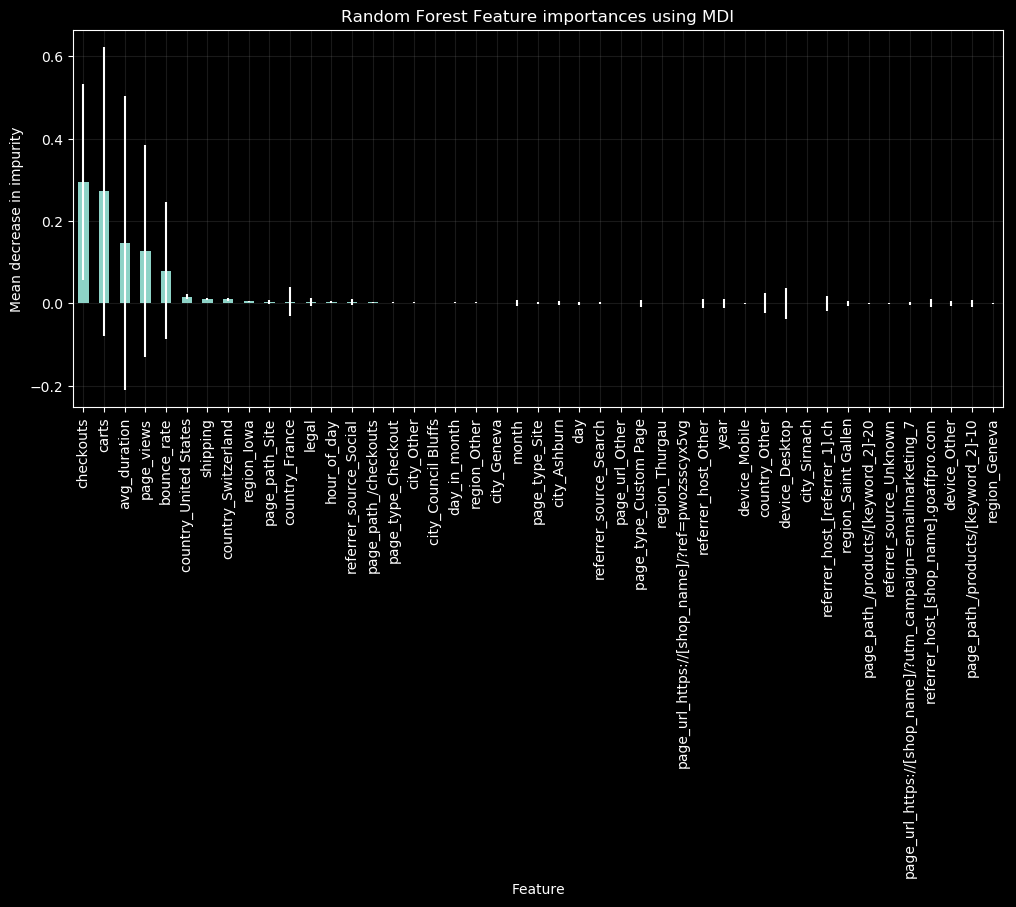

In [172]:
# Feature importance
draw_importance(rf_tree2)

ill-conditioning ?

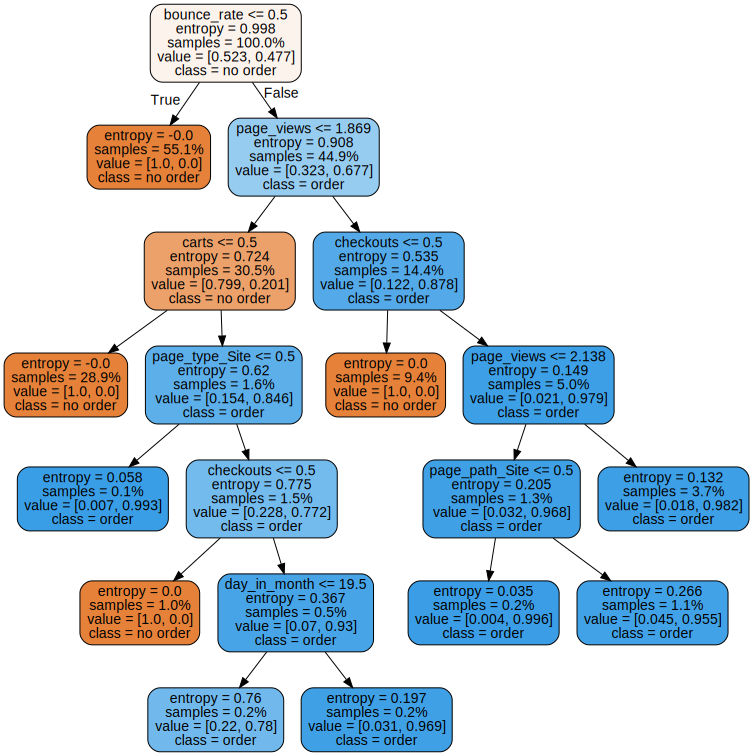

In [173]:
# Plot individual tree
draw_tree(rf_tree2, 'Random_Forest_tree_2')

We get a simpler tree. But it is now underfitting. Precision decreases as the model predict more samples as `order`.

### Logistic Regression

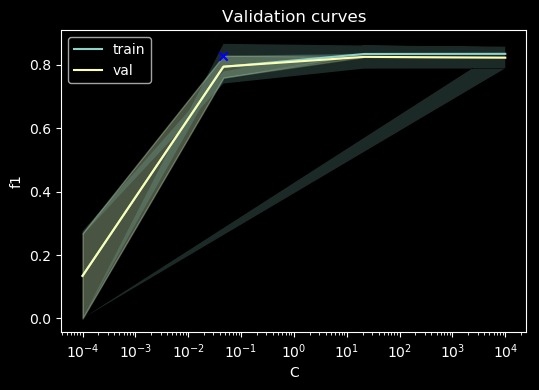

Best params: {'logistic__C': 0.046415888336127774, 'logistic__penalty': 'l1'}
f1 validation score = 0.829



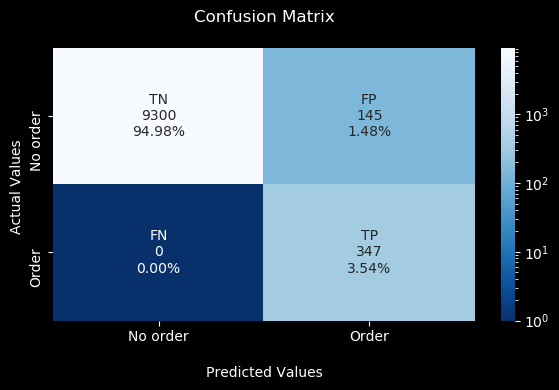


Classification report [whole train set]:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9445
           1       0.71      1.00      0.83       347

   micro avg       0.99      0.99      0.99      9792
   macro avg       0.85      0.99      0.91      9792
weighted avg       0.99      0.99      0.99      9792

f1 train score = 0.827

### test set ###



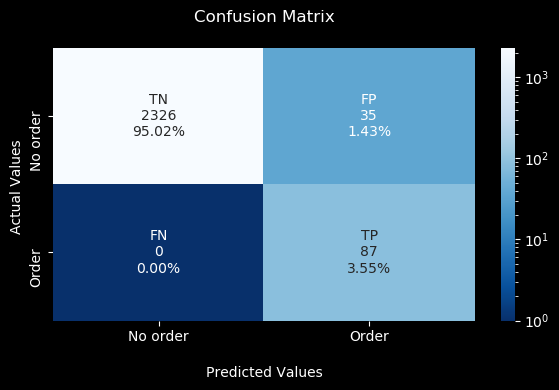


Classification report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2361
           1       0.71      1.00      0.83        87

   micro avg       0.99      0.99      0.99      2448
   macro avg       0.86      0.99      0.91      2448
weighted avg       0.99      0.99      0.99      2448

f1 test score = 0.833



In [22]:
# Logistic Regression
lr_full_pred, lr_full_f1_tr, lr_full_f1_te, lr_full_proba, lr_gridsearch = model_lr(X_tr, X_te, y_tr, y_te)

The Logistic Regression model reaches an f1-score of 83%, in line with the train score (82%).

On the validation curves graph, we can see that the train/test mean curves are overlapping. The train set reaches a ceiling at around 80%, which is below the first two models.

Proportions of TN/FP/FN/TP are almost the same as well as the f-1 score. Precision is low at 71%. Recall is at 100% due to 0 FN on both the train/test, suggesting overfitting.

- No_order category:
        - Precision and recall are again almost perfect with respective scores of 100% and 99%.
- Order category:
        - Precision has the lowest score of all 3 models with 71%. There are 35 FP out of 122 predicted positive values. In the other hand, the model has the highest number of TP.
        - Recall is perfect with 0 FN out of 87 positive records translating in a score of 100%, but for the price of a poor precision score.

#### Coefficient Importance
Let's check the coefficients used by the model

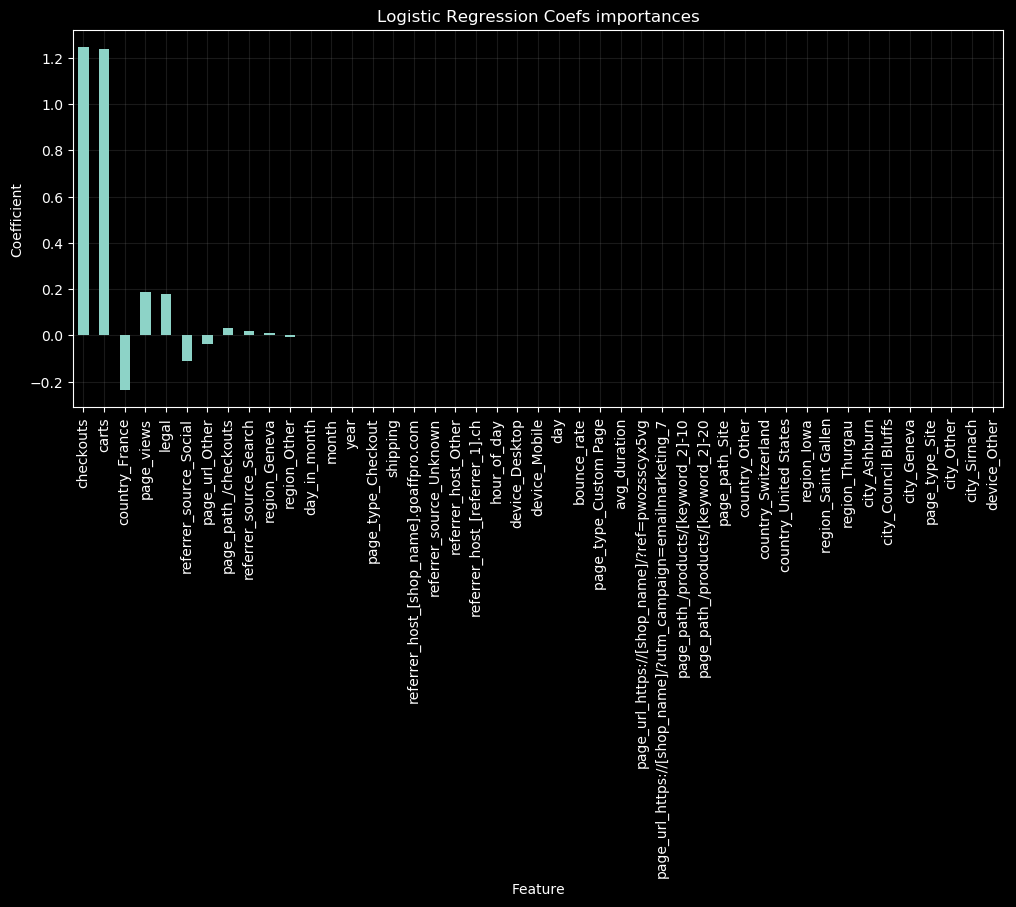

In [77]:
importances = lr_gridsearch.best_estimator_.named_steps['logistic'].coef_

lr_importances = pd.Series(importances[0,:], index=feature_names)
lr_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(12,5))
lr_importances[lr_importances.abs().sort_values(ascending = False).index].plot.bar(ax=ax)
ax.set_title("Logistic Regression Coefs importances")
ax.set_ylabel("Coefficient")
ax.set_xlabel("Feature")
ax.grid(color='gray', alpha=.2, axis='both')
fig.tight_layout()

The Logistic Regression model takes only 11 features to make its predictions. The other ones are not used at all. The model use a different set of features than Random Forest. `country_France`, `legal`, `refferer_source_Social` are relatively important for the Logistic Regression, but not really for Random Forest. The EDA showed that the features used by Random Forest are better predictors than the ones used here by Logistic Regression.


`checkouts` and `carts` are extremely important compared to the other coefficents. It seems that the Logistic Regression model is less able to capture inforamtion than Random Forest. Again, we could trim some features to reduce the complexity since the model is not using them at all.

### Precision/Recall

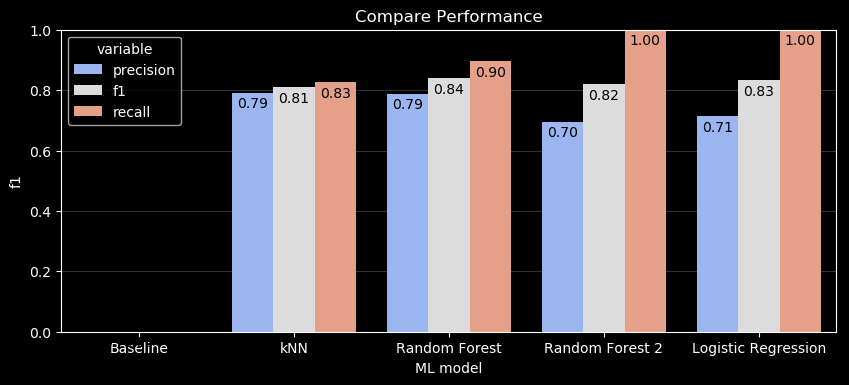

In [166]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Plot Precision / Recall
table = []
for x, y in zip([baseline_full_pred, kNN_full_pred, rf_full_pred, rf_full_pred2, lr_full_pred], ['Baseline', 'kNN', 'Random Forest', 'Random Forest 2', 'Logistic Regression']):
    pre = precision_score(y_te, x)
    rec = recall_score(y_te, x)
    table.append({
        'model': y,
        'precision': pre,
        'recall': rec
    })


table = pd.DataFrame(table)

# add f1 scores
f1_scores = [baseline_full_f1, kNN_full_f1_te, rf_full_f1_te, rf_full_f1_te2, lr_full_f1_te]
table['f1'] = f1_scores

table = table[['model', 'precision', 'f1', 'recall']]
table

table = table.melt(id_vars='model')

# Plot Results
fig, ax = plt.subplots(1,1,figsize=(10, 4))
plt.title('Compare Performance')

sns.barplot(table.model, table['value'], hue=table['variable'], palette='coolwarm')
ax.grid(alpha=.2, axis='y')
ax.set_xlabel('ML model')
ax.set_ylim([0, 1])
ax.set_ylabel('f1')

show_values_on_bars(ax)

plt.show()

# f1 = 2 * (precision * recall) / (precision + recall)

We can clearly see here that the f1 score alone is not enough to evaluate the best model. Taking that score alone, we could think that the `Logistic Regression` model is very similar to the `Random Forest` one (0.85 vs 0.83). However, we see here that the latter has a higher contrast of Precision/Recall scores that will translate into different prediction behaviors, espacially a poor precision.

Suprisingly, the kNN model is the most balanced model in terms of Precision/Recall scores.

Let's compare the prediction probabilities of each model and get more insights on each model's behavior.

# Compare probabilities

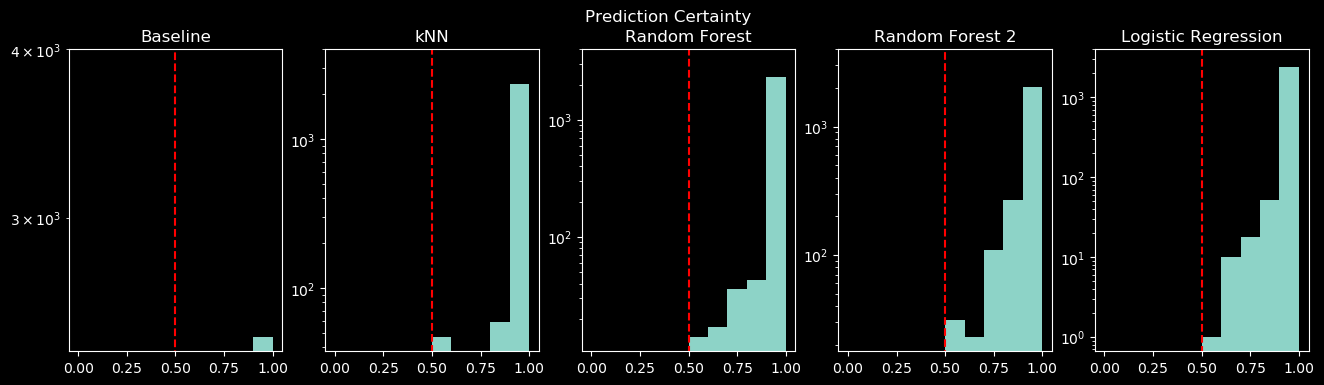

In [174]:
fig, ax = plt.subplots(1,5,figsize=(16, 4))
fig.suptitle('Prediction Certainty')

ax[0].hist(baseline_full_proba.max(axis=1), bins=np.arange(0, 1.01, 0.1), log=True)
ax[0].set_title("Baseline")
ax[0].vlines(0.5, 0, 4000, colors='r', linestyles='dashed')
ax[0].set_ylim([0, 4000])

ax[1].hist(kNN_full_proba.max(axis=1), bins=np.arange(0, 1.01, 0.1), log=True)
ax[1].set_title("kNN")
ax[1].vlines(0.5, 0, 4000, colors='r', linestyles='dashed')
ax[1].set_ylim([0, 4000])

ax[2].hist(rf_full_proba.max(axis=1), bins=np.arange(0, 1.01, 0.1), log=True)
ax[2].set_title("Random Forest")
ax[2].vlines(0.5, 0, 4000, colors='r', linestyles='dashed')
ax[2].set_ylim([0, 4000])

ax[3].hist(rf_full_proba2.max(axis=1), bins=np.arange(0, 1.01, 0.1), log=True)
ax[3].set_title("Random Forest 2")
ax[3].vlines(0.5, 0, 4000, colors='r', linestyles='dashed')
ax[3].set_ylim([0, 4000])

ax[4].hist(lr_full_proba.max(axis=1), bins=np.arange(0, 1.01, 0.1), log=True)
ax[4].set_title("Logistic Regression")
ax[4].vlines(0.5, 0, 4000, colors='r', linestyles='dashed')
ax[4].set_ylim([0, 4000])

plt.show()

All model are confident about their predictions. There is no sample below 0.5. `Logistic Regression` is the one that is the less confident. `kNN` might be too confident.   
Let's look at the probability distribution to find out.

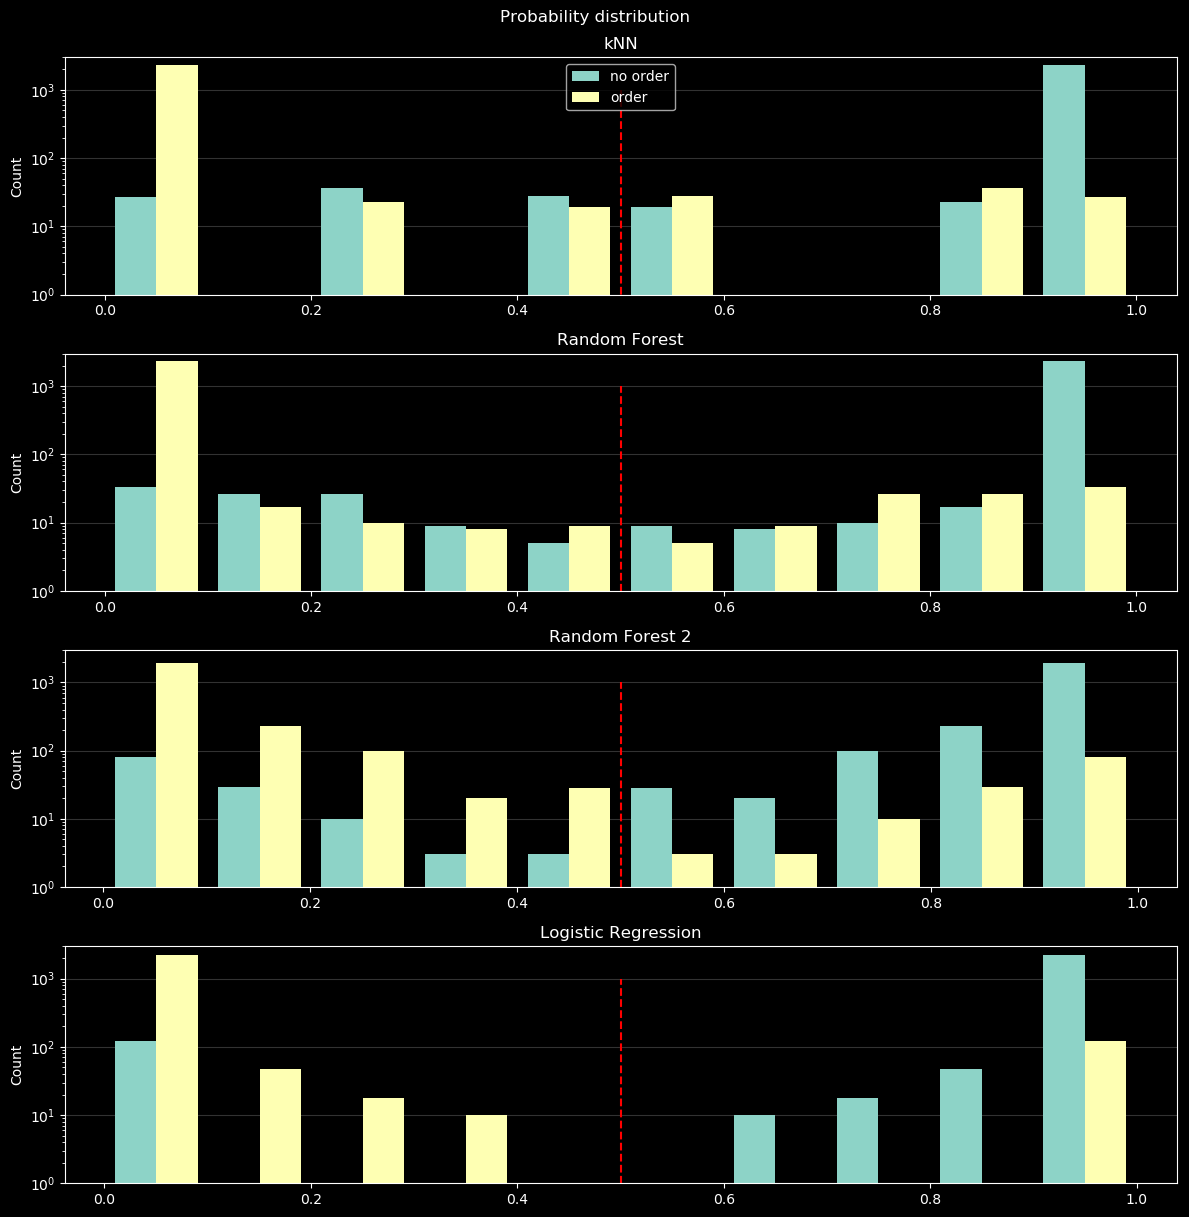

In [175]:
labels = ['no order','order']

fig, ax = plt.subplots(4,1,figsize=(12, 12))
fig.suptitle('Probability distribution', y=1.01)

ax[0].hist(kNN_full_proba, log=True)
ax[0].legend(labels)
ax[0].vlines(0.5, 0, 1000, colors='r', linestyles='dashed')
ax[0].set_title("kNN")
ax[0].set_ylabel('Count')
ax[0].grid(alpha=.2, axis='y')
ax[0].set_ylim([1, 3000])

ax[1].hist(rf_full_proba, log=True)
ax[1].vlines(0.5, 0, 1000, colors='r', linestyles='dashed')
ax[1].set_title("Random Forest")
ax[1].set_ylabel('Count')
ax[1].grid(alpha=.2, axis='y')
ax[1].set_ylim([1, 3000])

ax[2].hist(rf_full_proba2, log=True)
ax[2].vlines(0.5, 0, 1000, colors='r', linestyles='dashed')
ax[2].set_title("Random Forest 2")
ax[2].set_ylabel('Count')
ax[2].grid(alpha=.2, axis='y')
ax[2].set_ylim([1, 3000])

ax[3].hist(lr_full_proba, log=True)
ax[3].vlines(0.5, 0, 1000, colors='r', linestyles='dashed')
ax[3].set_title("Logistic Regression")
ax[3].set_ylabel('Count')
ax[3].grid(alpha=.2, axis='y')
ax[3].set_ylim([1, 3000])

fig.tight_layout()
plt.show()

All 3 models show the same number of `no_order` with 1.0 of confidence. These samples are easy to predict for all 3 models.  
On the other hand, all 3 models show the same number `order` with 0.1 confidence. These are samples that all models struggle to predict. It is a sign that the data lacks information to properly predict the `order` class. 

The difference between models are in the middle:

- kNN is the less precise with its probabilities.

- Random Forest is more nuanced and shows a U-shape.

- Logistic Regression model predicts `orders` excusively above 0.9 or below 0.5 while `no_orders` exclusively below 0.1 or above 0.5, suggesting overfitting.

Random Forest seems like the best model here. It seems that it is the model that capture the more information from the data, translating in more nuanced predictions.

## Prediction Grid

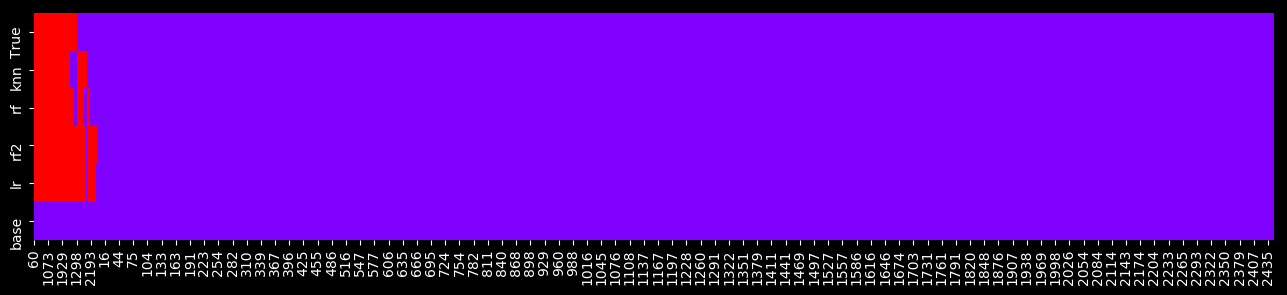

In [176]:
# Prediction Grid
prediction_grid = pd.DataFrame(np.array(np.vstack((y_te, kNN_full_pred, rf_full_pred, rf_full_pred2, lr_full_pred, baseline_full_pred))),
                               index=['True', 'knn', 'rf', 'rf2', 'lr', 'base'])
prediction_grid = prediction_grid.T.sort_values(by=prediction_grid.index.tolist(), ascending=False).T

plt.figure(figsize=(16,3))
sns.heatmap(prediction_grid, cmap='rainbow', cbar=False)
plt.show()

This graph is based on the prediction data from the test set. It is the same prediction data from the confusion matrixes above but presented in a different form.

- Compared to kNN, Random Forest has more TP (red under True[red]), less FN (blue under True[red]), but slightly more FP (red under True[blue]).

- The logistic Regression model shows how it overfits (high number of FP, no FN) translating in a long red bar going to the right of the chart.

Random Forest Model seems to be the best one. It is more balanced and shows good precision/recall performance.

## Conclusion

- All models perform better than the baseline. 
- As expected, distanced-based models are not the best for this particular problem, even if performances are close.
- All models seem to overfit. Logistic Regression is the most obvious one.
- kNN works suprisingly well compared to the Random Forest model. But still, it looks like the latter is the best model for our problem.
- The data clearly lacks features that will allow our models to understand its comlpexity.
- There are too many uneeded features in our data. 
- The feature `checkouts` is maybe too correlated with the target value. It is so close in the customer funnel to the order confirmation that it may tend to "bend" the whole models around it. It could be interesting to train the models without it and see the results.

To go further:
It would be interesting to fit the models with a lower set of features (1<x<45) and see how models are reacting. This would decrease the complexity of the models and therefore decrease the overfitting issue. It may also increase the whole performances. Since Logistic Regression is not using most of the features, we should not see any difference with the latter, but kNN and Random Forest should show some difference.

Models are not able to capture the whole complexity from the data. in terms of bias-variance trade-off, less features are needed to decrease the overfitting but important features are still missing on the data set that would avoid the model to underfit. For example, some trackers (user ID)  could allow us to group all visits made by the same user or help us capture the real effects from marketing actions. Google Analytics has tools that allow that. However, the goal of this project was to see what level of performance we can expect from the raw data coming only from the Shopify Analytics page. Most e-commerce shops do not have complex Google Analytics integration and the data presented here is very often all they have to offer. Therefore, this project show us what we can expect from such analyses.

